# An interesting piece-fitting puzzle

### [Ben North](http://www.redfrontdoor.org/blog/), December 2017

Via [mathblogging.org](https://mathblogging.org/), I came across [Math=Love's blog entry](https://mathequalslove.blogspot.ie/2017/11/color-square-puzzle-from-puzzle-box.html) describing a piece-fitting puzzle, and thought it would be interesting to solve it exhaustively and answer the question in the blog entry: _So far, we have found two different possible solutions. I'm looking forward to collecting data to help determine if there are more!_

## The puzzle

The puzzle comes from the book [Puzzle Box, Volume 1](http://store.doverpublications.com/0486810046.html), by Bram Cohen, Serhiy Grabarchuk, Peter Winkler, Peter Grabarchuk, and Andrea Gilbert.

Our task is to fit eight coloured pieces into a grid, but with the constraint that same-colour pieces cannot touch, even corner-to-corner:

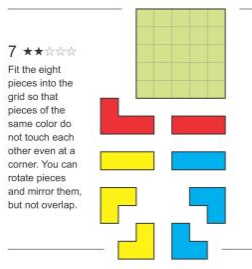

In [1]:
from IPython.display import Image
Image('Puzzle-Box-extract-via-Amazon-look-inside.png')

# Define piece shapes

There are eight pieces, but only three different shapes: 'ell', 'bar', and 'elbow'.  We will try to keep straight which idea we're talking about:

* A __shape__ is one of 'ell', 'bar', 'elbow'.  There are only three _shapes_ in the puzzle;
* A __piece__ is one of 'the red ell', 'the first yellow elbow', etc.  There are eight _pieces_ in the puzzle.

We first create a 2D numpy array for each different shape, in a rectangle where an element of 1 means the shape occupies that square, and an element of 0 means it doesn't.

In [2]:
import numpy as np
from functools import partial

u8_array = partial(np.array, dtype=np.uint8)
shape_ell = u8_array([[1, 0, 0], [1, 1, 1]])
shape_bar = u8_array([[1, 1, 1]])
shape_elbow = u8_array([[1, 0], [1, 1]])

# Compute all placements of a shape

We will need some functions to work out all the different ways of placing a particular shape, where we can translate, rotate, and reflect it.  Some shapes are symmetrical so we don't want to duplicate possibilities.  Also, we look ahead to the fact that we'll only allow the red 'ell' shape to be in its original orientation, to avoid generating all rotations and reflections of each whole solution.

## (Helper definitions and functions)

In [3]:
def u8_zeros(n_rows, n_cols):
    return np.zeros((n_rows, n_cols), dtype=np.uint8)

G_grid_sz = 5

new_empty_grid = partial(u8_zeros, G_grid_sz, G_grid_sz)

## Compute list of all possible translations of a shape

Each result of the translation process is a 5x5 grid with the squares occupied by the piece set to '1' and the rest '0'.

In [4]:
def translated(pc, dx, dy):
    # numpy arrays are indexed [row, col], i.e., [y, x]
    pc_ht, pc_wd = pc.shape
    full_pc = new_empty_grid()
    full_pc[dy:(dy + pc_ht), dx:(dx + pc_wd)] = pc
    return full_pc

In [5]:
def all_translations(pc):
    pc_ht, pc_wd = pc.shape
    n_x_shifts = G_grid_sz - pc_wd + 1
    n_y_shifts = G_grid_sz - pc_ht + 1
    return [translated(pc, x, y)
            for x in range(0, n_x_shifts)
            for y in range(0, n_y_shifts)]    

## Compute list of all possible rotations of a shape

In [6]:
rotated = np.rot90

def all_rotations(pc):
    # Hard-code '4 right angles in a full rotation':
    return [rotated(pc, k) for k in range(4)]

## What about reflection?

Only the red 'ell' is not reflection-symmetric, and we have chosen to keep it its original way up to define the rotation/reflection of the overall solution.  So we don't need to think about reflecting any of the other shapes.  This is a handy property of this particular puzzle; other similar puzzles might require a different approach.

## Put these together to create all transformations

In [7]:
from functools import reduce
from operator import concat

def all_transformation_results(pc):
    return reduce(concat,
                  (all_translations(rotated_pc)
                   for rotated_pc in all_rotations(pc)),
                  [])

But rotating the bar shape by 180 degrees leaves it unchanged, so we have over-counted; we need to pick out just unique grids.

In [8]:
def all_placements(pc):
    raw_placements = np.array(all_transformation_results(pc))
    return np.unique(raw_placements, axis=0)

# Find all placements of each shape

Again, we're relying on the two facts:

* There is only one 'ell'-shaped piece;
* For that piece, we only consider translations.

For the other two shapes, we need all possible transformations.

In [9]:
placements_ell = all_translations(shape_ell)
placements_bar = all_placements(shape_bar)
placements_elbow = all_placements(shape_elbow)

# A placement prohibits 'touching' placements

When a particular piece is placed, we want to know which grid cells are prohibited for other pieces of the same colour.  We need to compute the 'prohibition grid' for each placement, by expanding outwards in each of the eight possible directions (because 'touching at corners' is included in the rules) a square counts as 'touching' another.

In [10]:
def expand_8_neighbours(p):
    # Allow room for offset placements to 'stick out'
    # beyond actual puzzle grid.
    bigger_grid = u8_zeros(G_grid_sz + 2, G_grid_sz + 2)
    # The location itself is prohibited, so (dx=0, dy=0)
    # is included:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            bigger_grid[(dy + 1):(dy + G_grid_sz + 1),
                        (dx + 1):(dx + G_grid_sz + 1)] |= p
    return bigger_grid[1:-1, 1:-1]

def prohibitions(placements):
    return list(map(expand_8_neighbours, placements))

And we can now find the prohibitions for the list of placements for each shape.

In [11]:
prohibitions_ell = prohibitions(placements_ell)
prohibitions_bar = prohibitions(placements_bar)
prohibitions_elbow = prohibitions(placements_elbow)

# Define a `Shape` class

We'll collect these two pieces of information together into a class for ease of use later, and define the three 'shape' objects.

In [12]:
import attr

@attr.s
class Shape:
    placements = attr.ib()
    prohibitions = attr.ib()

In [13]:
shape_ell = Shape(placements_ell, prohibitions_ell)
shape_bar = Shape(placements_bar, prohibitions_bar)
shape_elbow = Shape(placements_elbow, prohibitions_elbow)

# Avoiding duplicate solutions

There are two ways that duplicate solutions will be generated if we aren't careful.

* There are two yellow elbows.  The straightforward brute-force approach would generate two 'different' solutions where the only difference is that the two elbows are swapped.  Same for the two blue elbows;
* The collection of yellow pieces is the same as the collection of blue pieces.  Again, the obvious approach would generate pairs of solutions differing only by interchange of yellow and blue.

We will address these in the same underlying way.

For the two yellow elbows, we will require that the second one has a placement later in the list of possible 'elbow' placements than the first one.  Similarly for the two blue elbows.

To break the yellow/blue symmetry, we will require that the blue bar has a 'later' placement than the yellow one.

Each piece _P_ therefore might have a 'predecessor' _Q_, such that _P_ must be placed using a later placement than _Q_.  (And so _P_ and _Q_ must have the same shape.)

# Creating pieces from shapes

We now have an idea of what information we'll need to define a 'piece'.  We need to know what colour it is; what, if any, its 'predecessor' is, and what 'shape' it is.

In [14]:
@attr.s
class Piece:
    colour_idx = attr.ib()
    pred_idx = attr.ib()
    shape = attr.ib()

We have everything we need to represent the pieces from the puzzle in this form, noting the 'predecessor' of the three pieces needing one.  These are numbers 4, 5, and 7 in the following.  Pieces not having a predecessor will use '-1' for their predecessor-index.

In [15]:
red_idx = 0
yellow_idx = 1
blue_idx = 2

pieces = [
    Piece(red_idx,    -1, shape_ell),   # 0
    Piece(red_idx,    -1, shape_bar),   # 1
    Piece(yellow_idx, -1, shape_bar),   # 2
    Piece(yellow_idx, -1, shape_elbow), # 3
    Piece(yellow_idx,  3, shape_elbow), # 4
    Piece(blue_idx,    2, shape_bar),   # 5
    Piece(blue_idx,   -1, shape_elbow), # 6
    Piece(blue_idx,    6, shape_elbow)  # 7
]

n_pieces = len(pieces)

# Computing all solutions

We will try placing each piece in turn, in all the possible placements its shape can have.  To be allowed to continue, that placement cannot overlap with any already-occupied square.  Neither can it overlap with the 'prohibited' squares of its own colour.  So we need to track:

* Which pieces have been placed where, by means of a list of indexes into each piece's shape's placement list;
* What squares are occupied (by a piece of any colour);
* For each colour, what squares are prohibited from being used by other pieces of that colour.

Then we need to be able to:

* Create a 'starting' / 'empty' solution with no pieces placed;
* Attempt to put a particular piece in a particular placement — this can fail if that placement would involve occupied or prohibited squares; or it can succeed, in which case we have a new partial solution;
* Generate all solutions, by trying each placement of each piece in turn, obeying 'predecessor' constraints where they exist.

We'll use the global `pieces` list for reference data.

In [16]:
@attr.s
class PartialSolution:
    placed_pieces = attr.ib()
    occupied = attr.ib()
    colour_prohibitions = attr.ib()
    
    @classmethod
    def new_empty(cls):
        n_colours = len(set(pc.colour_idx for pc in pieces))
        return cls([],
                   new_empty_grid(),
                   [new_empty_grid() for _ in range(n_colours)])
    
    def maybe_place(self, piece_idx, placement_idx):
        pc = pieces[piece_idx]
        colour_prohibition = self.colour_prohibitions[pc.colour_idx]
        sh = pc.shape
        plc = sh.placements[placement_idx]
        if np.any(colour_prohibition & plc):
            return None
        if np.any(self.occupied & plc):
            return None
        return PartialSolution(self.placed_pieces + [placement_idx],
                               self.occupied | plc,
                               [(colour_prohib | sh.prohibitions[placement_idx]
                                 if colour_idx == pc.colour_idx
                                 else colour_prohib)
                                for colour_idx, colour_prohib
                                in enumerate(self.colour_prohibitions)])

    def emit_completions(self, collect_full):
        next_piece_idx = len(self.placed_pieces)
        if next_piece_idx == n_pieces:
            collect_full(self)
        else:
            next_piece = pieces[next_piece_idx]
            placement_start = (0 if next_piece.pred_idx == -1
                               else self.placed_pieces[next_piece.pred_idx] + 1)
            for place in range(placement_start, len(next_piece.shape.placements)):
                maybe_next_soln = self.maybe_place(next_piece_idx, place)
                if maybe_next_soln is not None:
                    maybe_next_soln.emit_completions(collect_full)

## Go!

This takes a short while (around ten seconds) to run:

In [17]:
solns = []
PartialSolution.new_empty().emit_completions(solns.append)
len(solns)

2

We have found two essentially different solutions.

# Display the solutions

We will turn a solution into an RGB image by filling in the squares according to the colours of each piece's final placement in that solution.

In [18]:
def soln_as_image(soln):
    colours = [[210, 0, 0], [255, 255, 0], [96, 96, 240]]
    img = np.zeros((G_grid_sz, G_grid_sz, 3), dtype=np.uint8)
    for piece_idx, plc in enumerate(soln.placed_pieces):
        pc = pieces[piece_idx]
        colour = np.array(colours[pc.colour_idx], dtype=np.uint8)[None, None, :]
        piece_img = pieces[piece_idx].shape.placements[plc][:, :, None] * colour
        img += piece_img
    return img

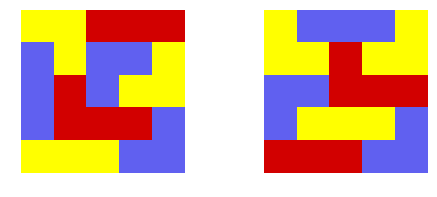

In [19]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(8.0, 3.0))
for i, s in enumerate(solns, start=1):
    plt.subplot(1, 2, i)
    plt.axis('off')
    plt.imshow(soln_as_image(s))

These are the only two essentially unique solutions.  To get 'more' solutions, we could independently: swap the two yellow elbows; swap the two blue elbows; swap yellow and blue pieces; rotate/reflect the whole solution.

# Test our approach to uniqueness

We can check that we get the expected duplication if we say each piece has no predecessor.  This takes a bit longer (around 30″):

In [20]:
# It's a bit sloppy to change the value of this global
# variable, but never mind.

pieces = [
    Piece(red_idx,    -1, shape_ell),   # 0
    Piece(red_idx,    -1, shape_bar),   # 1
    Piece(yellow_idx, -1, shape_bar),   # 2
    Piece(yellow_idx, -1, shape_elbow), # 3
    Piece(yellow_idx, -1, shape_elbow), # 4
    Piece(blue_idx,   -1, shape_bar),   # 5
    Piece(blue_idx,   -1, shape_elbow), # 6
    Piece(blue_idx,   -1, shape_elbow)  # 7
]

non_unique_solns = []
PartialSolution.new_empty().emit_completions(non_unique_solns.append)

We're expecting an eight-fold increase in solutions, so from 2 to 16, arising from independently choosing 'swap two blue elbows'; 'swap two yellow elbows'; 'swap blue and yellow':

In [21]:
len(non_unique_solns)

16

## Display non-unique solutions

To plot them, we need to distinguish between the two elbows of each colour, so label them with 'A' and 'B':

In [22]:
def plot_labelled_soln(s):
    # Which pairs of pieces need to be distinguished:
    pieces_to_label = [[3, 4], [6, 7]]
    plt.axis('off')
    plt.imshow(soln_as_image(s))
    for pcs in pieces_to_label:
        for i, p in enumerate(pcs):
            # Find top-left-most square occupied by this piece:
            plc = s.placed_pieces[p]
            locs = np.where(pieces[p].shape.placements[plc])
            # Label it, recalling row/col vs x/y:
            label_x = locs[1][0]
            label_y = locs[0][0]
            plt.text(label_x, label_y, 'AB'[i],
                     fontsize=14.0,
                     ha='center', va='center')

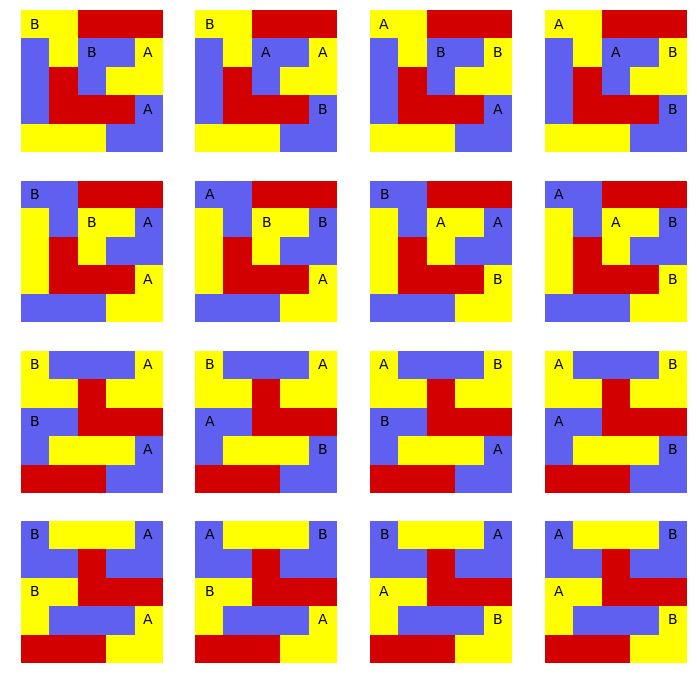

In [23]:
plt.figure(figsize=(12.0, 12.0))
for i, s in enumerate(non_unique_solns, start=1):
    plt.subplot(4, 4, i)
    plot_labelled_soln(s)

With the way the exploration happened to work out, we see the top eight solutions are essentially the same, once we count the various swaps as 'the same' solution.  Similarly for the bottom eight solutions.

## Allowing the 'red ell' to rotate or reflect

If we allowed ourselves to rotate or reflect the orientation-setting 'red ell' piece, each of these solutions would turn into eight, arising from four rotations and two reflections.  So you could say there are 96 solutions.

# About this document

Apart from the excerpt from 'Puzzle Box', this document and the code in it is Copyright 2017 Ben North.

Code is hereby made available under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.en.html), version 3 or later.

Non-code content is hereby made available under the [Creative Commons BY-SA 4.0 licence](https://creativecommons.org/licenses/by-sa/4.0/).

This document was generated from [this Jupyter notebook](An%20interesting%20piece-fitting%20puzzle.ipynb).

[Ben North](http://www.redfrontdoor.org/blog/), December 2017.